# Lab 1 - K-Nearest Neighbours

This lab is about the implementation and analysis of the KNN algorithm for classification problems

In [ ]:
### If you use colab uncomment these line and upload Material.zip

#from google.colab import files

#files.upload()
#!unzip Material.zip

In [2]:
# Packages used
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import griddata
import os
import pickle
np.random.seed(100)

### Data generation for binary classification

We start generating a training set for binary classification problems. Consider the following function, that generates random 2D points on the plane and assigns them a binary label according to their position w.r.t. a linear separator.

The function `linearBinaryClass`, given a sample size `n`, lower and upper bounds `low_D, high_D` for the domain of the samples and the linear function parameters `m, q`, generates a binary classification dataset i.e. it returns `X` and `Y`.

The signature of the function is the following:

`X, Y = linearBinaryClass(n, low_D, high_D, m, q)`

where
- **n** is the number of samples to be generated
- **low_D** and **high_D** are, respectively, the lower and upper bounds for the domain of the samples i.e.
    $$
    X_{i,j} \sim \mathcal{U}(\text{low_D}, \text{high_D})
    $$
- **m, q** are the linear function parameters
- **X**, **Y**: 2-dimensional samples (X) associated with 1-dimensional binary labels (Y)


In [3]:
def linearBinaryClass(n, low_D, high_D, m, q):
    X = (np.random.rand(n, 2) * (high_D - low_D)) + low_D
    Y = np.sign((X[:,1] - (m * X[:,0]) + q))
    Y[Y==0] = 1
    return X,Y

### Computing the distance between input points

In order to build the KNN estimator we need to resort to a distance function.

Consider a function that computes the euclidean distance between two points...

In [4]:
def euclidDistance(P1,P2):
    return np.linalg.norm(P1-P2,2)

... and then a function that computes all the distance between two set of points stored in two matrices.

In [5]:
def allDistances(X1, X2):
    D = np.zeros((X1.shape[0], X2.shape[0]))
    for idx1 in range(len(X1)):
        for idx2 in range(len(X2)):
            D[idx1,idx2] = euclidDistance(X1[idx1,:],X2[idx2,:])
    return D

The usage is the following:

**D = allDistances(X1,X2)**

where
- **X1** is a matrix of size $n_1 \times D$, where each row is a D-dimensional point
- **X2** is a matrix of size $n_2 \times D$, where each row is a D-dimensional point
- **D** is a matrix of size $n_1 \times n_2$, where each element `D[i,j]` is the distance between points (`X1[i, :]`, `X2[j, :]`)

### Adding noise to the samples

To make the task harder, we may want to perturb the labels with some noise.

In our case, we have binary labels and a common way of adding noise is to flip the value of a small percentage of the labels. For example, if a label was $+1$ it will become $-1$.

The `flipLabels` function takes two arguments:
 - `Y`, the numpy array of original labels
 - `P`, an integer between 1 and 100 specifying the percentage of labels which will be flipped
and returns an array of the same shape as `Y`, which contains the noisy labels.


In [11]:
indices_to_flip = np.random.choice(range(40, int(40 * (10 / 100))), replace=False)
print(indices_to_flip)

ValueError: 'a' cannot be empty unless no samples are taken

In [6]:
def flipLabels(Y, P):
    if P < 1 or P > 100:
        raise Exception('P should be between 1 and 100')
        
    indices_to_flip = np.random.choice(range(len(Y)), int(len(Y) * (P / 100)), replace=False)
    Y_noisy = Y.copy()
    Y_noisy[indices_to_flip] *= -1
    
    return Y_noisy


### Assignment 1: The KNN classifier

We are now ready to use the KNN algorithm to estimate the classification function. 

Implement the `kNNClassify` function which train a KNN classifier on given training set and returns predictions on a given test set. 

The signature of the function is the following:

`Ypred = kNNClassify(Xtr, Ytr, k, Xte)`

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered
- **Xte** is a matrix of size [nte, D], where each row is a D-dimensional point (INPUT IN THE **TEST SET**)
- **Ypred** is an array of size [nte], where each element is a binary label (ESTIMATED OUTPUT FOR THE **TEST SET**)

where [ntr] and [nte] are respectively the number of points in the training set and the number of points in the test set

In [7]:
def kNNClassify(Xtr, Ytr, k, Xte):

    n_train = Xtr.shape[0] # number of the training inputs
    n_test = Xte.shape[0] # number of the test inputs

    if any(np.abs(Ytr) != 1):
        raise Exception("The values of Ytr should be +1 or -1.")

    if k > n_train:
        print("k is greater than the number of points, setting k=n_train")
        k = n_train

    Ypred = np.zeros(n_test)

    # Compute all the distances from TEST input and TRAINING input
    dist = allDistances(Xtr, Xte)
    
    # For each test point, the predicted class will be 
    # the sign of the average label of the k nearest points
    for idx in range(n_test):
        # Hint 1: take all the distances for the current test point
        query_dist = dist[idx]
        # Hint 2: Sort the indices of the distances
        sorted_query_dist_idx = np.argsort(query_dist)
        # Hint 3: Get the indices of the k lowest of distances
        k_lowest = sorted_query_dist_idx[:k]
        # Hint 4: Compute the mean of the output values of the corresponding training points and taking the sign of it.
        Ypred[idx] = np.sign(np.mean(Ytr[k_lowest]))
                  
    return Ypred


### Visualizing the separating function

The visualization of the separating function on the training set, i.e. the function estimated by classification algorithm for discriminating between classes, is of benefit for appreciating the behavior of the binary classifier. To visualize the separating function use the following:

**_separatingFkNN(Xtr, Ytr, k)_**

where
- **Xtr** is a matrix of size [ntr, D], where each row is a D-dimensional point (INPUT IN THE **TRAINING SET**)
- **Ytr** is an array of size [ntr], where each element is a binary label (OUTPUT IN THE **TRAINING SET**)
- **k** is the number of neighbours to be considered

In [14]:
def separatingFkNN(Xtr, Ytr, k, Xte):
    Ypred = kNNClassify(Xtr=Xtr, Ytr=Ytr, k=k, Xte=Xte)

    x = Xtr[:, 0]
    y = Xtr[:, 1]
    xi = np.linspace(x.min(), x.max(), 200)
    yi = np.linspace(y.min(), y.max(), 200)
    zi = griddata((x, y), Ypred, (xi[None, :], yi[:, None]), method='linear')

    plt.subplots()
    CS = plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    plt.scatter(x, y, c=Ytr, marker='o', s=50, zorder=10, alpha=0.8)
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())
    msg = 'Separating function, k='+str(k);
    plt.title(msg)

### Evaluating the goodness of a classifier

To evaluate how good is the classification function estimated by the KNN, we compare the predicted binary labels and expected (true) ones, with the following function:

`err = calcError(Ypred, Ytrue)`

where
- **Ypred** is an array of size $n$, where each element is a binary label predicted by the classifier
- **Ytrue** is an array of size $n$, where each element is the true binary label
- **err** is the fraction of wrongly classified elements wrt the total number


In [13]:
def calcError(Ypred, Ytrue):
    return (np.count_nonzero(Ypred != Ytrue)) / len(Ytrue)

### Assignment 2: Noise-free case

In this assignment, we start to play with the NN classifier. In specific:

- 1.Generate a training set WITHOUT NOISE
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Compute the error on the TRAINING and then on the TEST SET



With K=3 the error on the test set is  0.515
With K=3 the error on the training set is  0.02


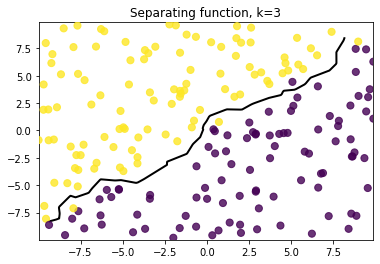

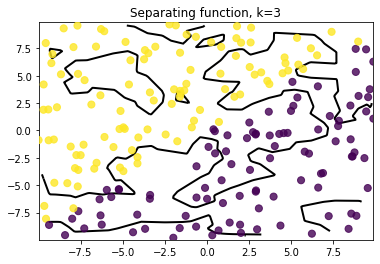

In [20]:
### Generate training and test sets, build and evaluate the KNN classifier
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 3

#TODO: Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)

#TODO: Visualize the separating curve for the NN classifier on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xtr)

#TODO: Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

separatingFkNN(Xtr, Ytr, k, Xte)

#TODO: Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

#TODO: Compute the error on the TEST SET
err = calcError(Ypred ,Yte)

print("With K=%d the error on the test set is " % (k), err)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr = calcError(Ypredtr ,Ytr)
print("With K=%d the error on the training set is " % (k), errtr)

### Assignment 3: adding noise

Keeping the parameters of the function and the number of points as in the previous assignment:

- 1.Generate a training set WITH NOISE (for instance with 10% of flipped labels)
- 2.Visualize the separating curve for the **NN** classifier 
- 3.Generate a test set with the same amount of noise as the training set.
- 4.Evaluate the NN classifier on the TRAINING and on the TEST SET
- 5.Compute the obtained error on the TRAINING and on the TEST SET

- Repeat the steps from 1 to 5 with the **KNN** algorithm, setting for instance K=5

OBSERVE WHAT CHANGES...

With K=7 the error on the test set is  0.51
With K=7 the error on the training set is  0.105


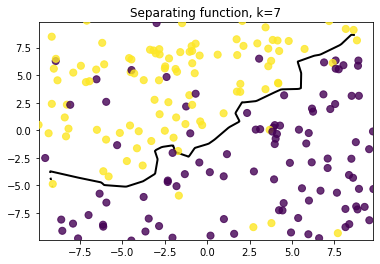

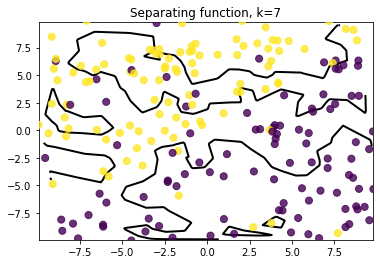

In [24]:
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 7
noise = 10

#TODO: Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
Ytr = flipLabels(Ytr, noise)

#TODO: Visualize the separating curve for the NN classifier on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xtr)

#TODO: Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

separatingFkNN(Xtr, Ytr, k, Xte)

#TODO: Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

#TODO: Compute the error on the TEST SET
err = calcError(Ypred ,Yte)

print("With K=%d the error on the test set is " % (k), err)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr = calcError(Ypredtr ,Ytr)
print("With K=%d the error on the training set is " % (k), errtr)

Describe here what changes: 

### Assignment 4

Analyse the performance of the **KNN** with plots, considering in particular the following:



- **SCENARIO 1**: Fix the number n of points to 200, fix the amount of noise to 10%, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the value of K

- **SCENARIO 2**: Fix the number n of points to 200, fix the value of K to a reasonable number of neighbours, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the amount of noise

- **SCENARIO 3**: Fix noise and K to two reasonable values, fix the number of TEST samples to 300, and plot the performance of the KNN classifier on TRAINING and TEST SETS as you increase the number of TRAINING samples (e.g. from 30 to 300 with steps 30)

For each scenario, describe what happen

With K=9 the error on the test set is  0.505
With K=9 the error on the training set is  0.145


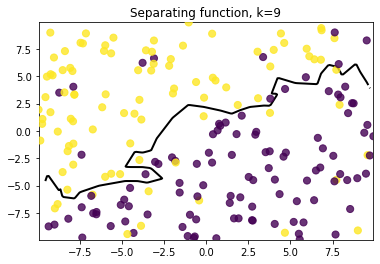

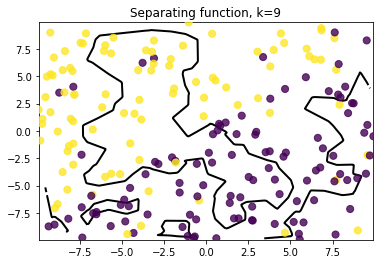

In [37]:
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 9
noise = 10

#TODO: Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
Ytr = flipLabels(Ytr, noise)

#TODO: Visualize the separating curve for the NN classifier on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xtr)

#TODO: Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

separatingFkNN(Xtr, Ytr, k, Xte)

#TODO: Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

#TODO: Compute the error on the TEST SET
err = calcError(Ypred ,Yte)

print("With K=%d the error on the test set is " % (k), err)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr = calcError(Ypredtr ,Ytr)
print("With K=%d the error on the training set is " % (k), errtr)

With K=5 the error on the test set is  0.425
With K=5 the error on the training set is  0.115


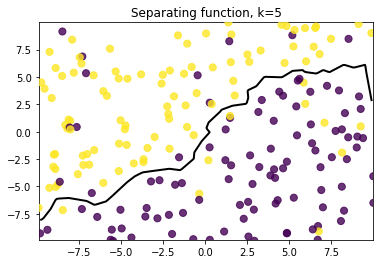

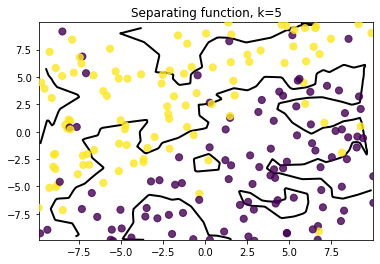

In [40]:
n = 200
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 5
noise = 10

#TODO: Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
Ytr = flipLabels(Ytr, noise)

#TODO: Visualize the separating curve for the NN classifier on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xtr)

#TODO: Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

separatingFkNN(Xtr, Ytr, k, Xte)

#TODO: Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

#TODO: Compute the error on the TEST SET
err = calcError(Ypred ,Yte)

print("With K=%d the error on the test set is " % (k), err)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr = calcError(Ypredtr ,Ytr)
print("With K=%d the error on the training set is " % (k), errtr)

In [ ]:
n = 300
D = 2

m = 0.9
q = 0.0

low_D = -10
high_D = 10

k = 7
noise = 10

#TODO: Generate a training set WITHOUT NOISE
Xtr, Ytr = linearBinaryClass(n, low_D, high_D, m, q)
Ytr = flipLabels(Ytr, noise)

#TODO: Visualize the separating curve for the NN classifier on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xtr)

#TODO: Generate a test set WITHOUT NOISE
Xte, Yte = linearBinaryClass(n, low_D, high_D, m, q)

separatingFkNN(Xtr, Ytr, k, Xte)

#TODO: Evaluate the NN classifier on the TEST SET
Ypred = kNNClassify(Xtr, Ytr, k, Xte)

#TODO: Compute the error on the TEST SET
err = calcError(Ypred ,Yte)

print("With K=%d the error on the test set is " % (k), err)

# How the classifier perform on the TRAINING SET instead?
Ypredtr = kNNClassify(Xtr, Ytr, k, Xtr)
errtr = calcError(Ypredtr ,Ytr)
print("With K=%d the error on the training set is " % (k), errtr)

Insert here your observations:
- **SCENARIO 1**: when we increase the k the model will fit the test data more, in high values the model will underfit the test data
- **SCENARIO 2**: when we increase the noise we need more k value
- **SCENARIO 3**: the more data we have the best values we get


## Cross-validation
In this part of the Lab, we focus on Cross-validation for model selection.

### Preliminaries: Data-loading

There are 4 datasets included with this lab, with the following properties:

  - (Training1, Test1): n=70, no noise, suggested K values are in the range 1 ... 13
  - (Training2, Test2): n=40, no noise, suggested K values are in the range 1 ... 23
  - (Training3, Test3): n=200, 20% flipped labels, suggested K values are in the range 1 ... 31
  - (Training4, Test4): n=200, 5% flipped labels, suggested K values are in the range 1 ... 19

Note that each dataset includes both a training and a test set. You **cannot use the test set to choose k**: you should assume you don't have access to the test set when doing model selection!

To load a dataset use function
`Xtr, Ytr, Xte, Yte = load_dataset(path_tr, path_te)`

Where:
- **_path\_tr_**: is the path to the file which contains the training set
- **_path\_te_**: is the path to the file which contains the test set

and it returns:
- **_Xtr_**: Inputs of training set
- **_Ytr_**: Outputs of training set
- **_Xte_**: Inputs of test set
- **_Yte_**: Outputs of test set

In [43]:
def load_dataset(path_tr, path_te):
    with open(path_tr,"rb") as f:
        [Xtr, Ytr] = pickle.load(f)
    with open(path_te,"rb") as f:
        [Xte, Yte] = pickle.load(f)
    return Xtr, Ytr, Xte, Yte

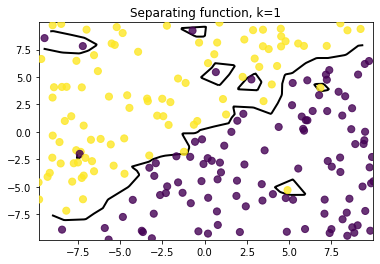

In [23]:
training_set_path = "./Material/Classification/Training4.dat"
test_set_path = "./Material/Classification/Test4.dat"
Xtr, Ytr, Xte, Yte = load_dataset(training_set_path, test_set_path)
separatingFkNN(Xtr, Ytr, 1, Xtr)

## Assignment 5: using the training set to choose k

Having noted that we cannot directly use the test set to find the best k, we can try to select it with the training set. 
Follow these steps, and fill in the blanks in the following cells. **Comment on your findings in the notebook**.

 1. Choose a list of values for k you want to try. Check the list of suggested values for any given dataset.
 2. For each value of k do:
     1. Train a k-NN classifier with the current value of k
     2. Evaluate the error of the trained model, **on the training set**
 3. The _best_ k is the one with the lowest training error!
 4. Train a k-NN model with the chosen k, and evaluate the error **on the test set**. Is the test error similar to the training error? Does the chosen k seem like a good one?

In [25]:
# Use dataset 4 for this task.
training_set_path = "./Material/Classification/Training4.dat"
test_set_path = "./Material/Classification/Test4.dat"
Xtr, Ytr, Xte, Yte = load_dataset(training_set_path, test_set_path)
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18 ,19]

# Insert your code here
k_tr_errors = []
for current_k in k_list:
    # TODO: train a k-NN model, calculate the error on the training set.
    Ypredtr = kNNClassify(Xtr, Ytr, current_k, Xtr)
    current_tr_err = calcError(Ypredtr ,Ytr)
    k_tr_errors.append(current_tr_err)

# TODO: pick the best value of k using k_list and k_tr_errors.
best_k = np.argmin(k_tr_errors) + 1

print(f"The best k chosen with the training-set is: {best_k}\n"
      f"with training error {np.min(k_tr_errors)*100:.2f}%")

The best k chosen with the training-set is: 1
with training error 0.00%


In [26]:
# Evaluate the model with the best k on the test set now
Ypredte = kNNClassify(Xtr, Ytr, 1, Xte)
te_err =  calcError(Ypredte ,Ytr)
    
print(f"The test error with the best k ({best_k}) is: {te_err*100:.2f}%")

The test error with the best k (1) is: 46.00%


Text(0.5, 1.0, 'Choosing k from the training set.')

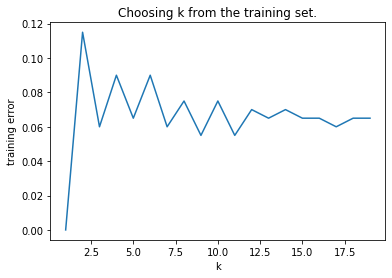

In [27]:
# Plot how the training error changes with k
fig, ax = plt.subplots()
ax.plot(k_list, k_tr_errors)
ax.set_xlabel("k")
ax.set_ylabel("training error")
ax.set_title("Choosing k from the training set.")

#### Observations: ...

## Assignment 6: K-Fold cross validation

The training error does not provide good estimates of the test error. So using the training error for model selection means you will select a k which is not good for the test set.

A simple way, which is much better than the training error, to estimate the test error is to use a **k-fold cross validation**. In K-Fold cross validation, the data are split into K parts of approximately equal size, and K different models are trained each time leaving out one of the parts of data. Then the estimate for the test error is the mean of the error of the K different models.

In this task you will implement K-Fold CV, and run the same analysis as in the previous cell.

In [74]:
def KFoldCVkNN(Xtr, Ytr, num_folds, k_list):
    """Run K-Fold CV for the kNN model
    
    Parameters:
    -----------
     - Xtr : np.array
         the full training set data
     - Ytr : np.array
         the full training set labels
     - num_folds : int
         the number of folds
     - k_list : List[int]
         the values of k (for k-NN) to try.
         
    Returns:
    --------
     - best_k : int
         The value of k (in k_list) which obtains the best average validation error
     - best_k_idx : int
         The index of the best_k element in k_list
     - tr_err_mean : np.array
         A 1D array of the same length as k_list, with the average training error for each tested k.
     - tr_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation 
         of the training error for each tested k.
     - val_err_mean : np.array
         A 1D array of the same length as k_list, with the average validation error for each tested k.
     - val_err_std : np.array
         A 1D array of the same length as k_list, with the standard deviation
         of the validation error for each tested k.
    """
    rnd_state = np.random.RandomState()
    # Ensures that k_list is a numpy array
    k_list = np.array(k_list)
    num_k = len(k_list)

    n_tot = Xtr.shape[0]
    n_val = n_tot // num_folds

    # We want to compute 1 error for each `k` and each fold
    tr_errors = np.zeros((num_k, num_folds))
    val_errors = np.zeros((num_k, num_folds))

    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = rnd_state.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    
    for fold_idx in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold_idx]] = True
        # Split training set in training part and validation part
        # Hint: you can use boolean mask as index vector to split Xtr and Ytr
        x_train =Xtr[~val_mask,:]
        y_train = Ytr[~val_mask,]
        x_val = Xtr[val_mask,:]
        y_val = Ytr[val_mask,]
        
        for k_idx, current_k in enumerate(k_list):
            # Compute the training error of the kNN classifier for the given value of k
            Ypredtr = kNNClassify(x_train, y_train, current_k, x_train)
            tr_errors[k_idx, fold_idx] = calcError(Ypredtr ,y_train)
            # Compute the validation error of the kNN classifier for the given value of k
            Ypredval = kNNClassify(x_train, y_train, current_k, x_val)
            val_errors[k_idx, fold_idx] = calcError(Ypredval ,y_val)
            
    # Calculate error statistics along the repetitions:
    # 1) mean training error, training error standard deviation
    tr_err_mean = np.mean(tr_errors, axis=1)
    tr_err_std = np.std(tr_errors, axis=1)
    # 2) mean validation error, validation error standard deviation
    val_err_mean = np.mean(val_errors, axis=1)
    val_err_std = np.std(val_errors, axis=1)
    # 3) best k (k which minimize mean validation error) and index of best k in k_list
    best_k = k_list[np.argmin(val_err_mean)]
    best_k_idx = np.argmin(val_err_mean)
    
    return best_k, best_k_idx, tr_err_mean, tr_err_std, val_err_mean, val_err_std

In [75]:
# Perform the same analysis of Assignment 5 using K-Fold CV
# INSERT YOUR CODE HERE
training_set_path = "./Material/Classification/Training4.dat"
test_set_path = "./Material/Classification/Test4.dat"
Xtr, Ytr, Xte, Yte = load_dataset(training_set_path, test_set_path)
k_list = [1, 2, 3, 4,]

print(KFoldCVkNN(Xtr, Ytr, 5, k_list))

(1, 0, array([0.     , 0.12375, 0.06375, 0.10125]), array([0.        , 0.02318405, 0.00728869, 0.00829156]), array([0.465, 0.675, 0.47 , 0.62 ]), array([0.07348469, 0.05700877, 0.03674235, 0.08124038]))


Does the best k (and the test error) change w.r.t. assignment 5?

## Assignment 7: Cross validation and Noise in k-NN

In this final task we consider the effect of noise on the best k (chosen with k-fold CV).

We will use dataset 3 which has high noise (20%), and dataset 4 which has low noise (5%).

You will have to do the following:
 1. Use k-fold CV to find the best k for datasets 3 and 4.
 2. Compare the obtained values of k, with the actual best k on the test error of the two datasets. This should be a sanity check: if the errors on k-fold CV and on the test set are very different, something may be wrong with your code.
 3. Comment on how noise affects the best k: does a more noisy dataset need a higher or a lower k, and why? It may be useful to plot the separating function (using the `separatingFkNN` function) of k-NN with the best k for the two datasets.

In [77]:
num_folds = 5
k_list = range(1, 19, 2)

**Dataset 3 (high noise)**

In [80]:
# Load dataset 3 (high noise)
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training3.dat", "./Material/Classification/Test3.dat")

In [81]:
k = KFoldCVkNN(Xtr, Ytr, num_folds, k_list)[0]
print(k)

5


In [83]:
#TODO: Compute the test error
Ypredte = kNNClassify(Xtr, Ytr, k, Xte)
te_err =  calcError(Ypredte ,Yte)
    
print(f"The test error with the best k ({k}) is: {te_err*100:.2f}%")

The test error with the best k (5) is: 47.50%


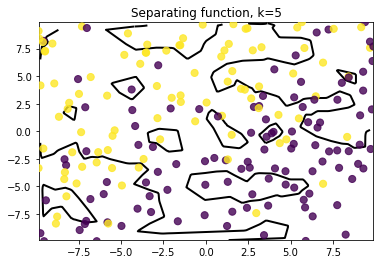

In [84]:
#TODO: Plot separatingFkNN on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xte)

**Dataset 4 (low noise)**

In [85]:
# Load dataset 4 (low noise)
Xtr, Ytr, Xte, Yte = load_dataset(
    "./Material/Classification/Training4.dat", "./Material/Classification/Test4.dat")

In [86]:
#TODO: Find the best k on the test set of dataset 4
k = KFoldCVkNN(Xtr, Ytr, num_folds, k_list)[0]
print(k)

3


In [87]:
#TODO: Compute the test error
Ypredte = kNNClassify(Xtr, Ytr, k, Xte)
te_err =  calcError(Ypredte ,Yte)
    
print(f"The test error with the best k ({k}) is: {te_err*100:.2f}%")

The test error with the best k (3) is: 50.00%


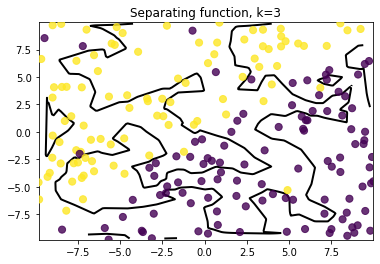

In [88]:
#TODO: Plot separatingFkNN on the TRAINING SET
separatingFkNN(Xtr, Ytr, k, Xte)

How does noise affect the best k?

#### Observations:...